In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from scipy.io import loadmat
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from scipy.sparse import csc_matrix, csr_matrix

np.set_printoptions(linewidth=1000)

In [183]:
d = 4
ind = [2, 3]
obj = [0, 1, 2]
U = unitary_group.rvs(2)
U = RZ(np.pi / 3).matrix()
Ud = np.eye(d, dtype=CDTYPE)
Ud[np.ix_(ind, ind)] = U
# print(Ud)

p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Ue = su2_encoding(Ud)
Up = Ue + p
# print(Up)

circ = Circuit()
circ += UnivMathGate('U', U).on(obj[0], obj[1:])
Uc = circ.matrix()
# print(Uc)

val1, vec1 = eig(Up)
val2, vec2 = eig(Uc)
sort1 = np.argsort(val1)
sort2 = np.argsort(val2)
val1 = val1[sort1]
val2 = val2[sort2]
vec1 = vec1[:, sort1]
vec2 = vec2[:, sort1]
print(approx_matrix(Up - vec1 @ np.diag(val1) @ inv(vec1)))
print(approx_matrix(Uc - vec2 @ np.diag(val2) @ inv(vec2)))
# c = vec1 @ inv(vec2)
# print(approx_matrix(c @ Uc @ inv(c)))

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j ]
 [ 0.       +0.j   0.1339746+0.5j  0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j ]
 [ 0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j ]
 [ 0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j   0.       +0.j ]
 [ 

[[1.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  1.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.8660254+0.j  0.       -0.5j]
 [0.       +0.j  0.       +0.j  0.       -0.5j 0.8660254+0.j ]]
[[ 1.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j          1.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          1.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          0.9553418+0.j          0.       +0.j         -0.0446582+0.j         -0.0446582+0.j          0.       -0.28867513j]

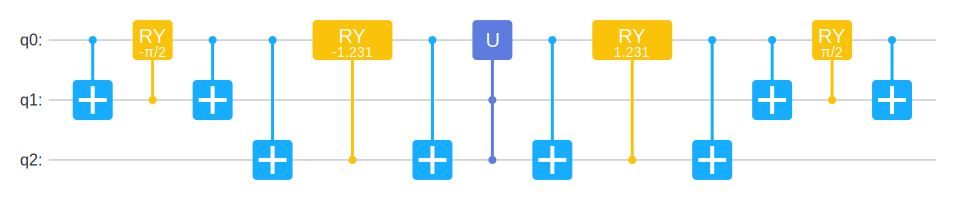

In [68]:
# Qubit ansatz of one-ququart unitary gate
d = 4
ind = [2, 3]
obj = [0, 1, 2]
U = unitary_group.rvs(2)
U = RX(np.pi / 3).matrix()
Ud = np.eye(d, dtype=CDTYPE)
Ud[np.ix_(ind, ind)] = U
print(Ud)

p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Ue = su2_encoding(Ud)
Up = Ue + p
print(Up)

circ = Circuit()
if ind == [0, 1]:
    corr = Circuit() + X(obj[1], obj[0]) + RY(np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(
        obj[2], obj[0]) + RY(np.arccos(1 / 3)).on(obj[0], obj[2]) + X(obj[2], obj[0]) + UN(X, obj[1:])
elif ind == [0, 2]:
    corr = Circuit()
elif ind == [0, 3]:
    corr = Circuit() + X(obj[0]) + X(obj[1], obj[0]) + X(obj[2], obj[0]) + X(obj[0])
elif ind == [1, 2]:
    corr = Circuit()
elif ind == [1, 3]:
    corr = Circuit()
elif ind == [2, 3]:
    corr = Circuit() + X(obj[1], obj[0]) + RY(-np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(
        obj[2], obj[0]) + RY(-np.arccos(1 / 3)).on(obj[0], obj[2]) + X(obj[2], obj[0])
circ += corr
circ += UnivMathGate('U', U).on(obj[0], obj[1:])
circ += corr.hermitian()
print(approx_matrix(circ.matrix()))
# print(su2_decoding(circ.matrix() - p))
print(np.allclose(Up, circ.matrix()))
circ.svg()

Hamiltonian Dimension: (8, 8)
Number of qubits: 3
Number of params: 1
Number of gates: 13
Loss: 0.000000000000000, Fidelity: 1.000000000000000,  10, 0.0036
Optimization terminated successfully.
Optimal: 0.00000000000000000000
psi norm: 1.24781146954059352083
psi fidelity: 0.06778795899388925794
{'b': -1.2309594173407779}


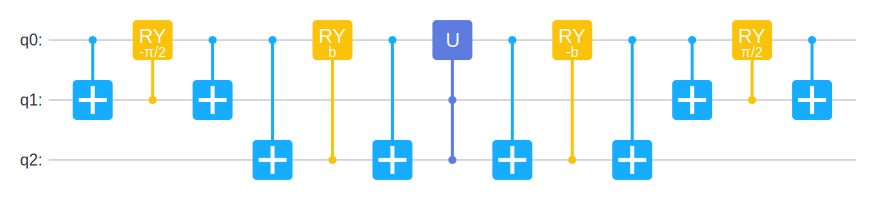

In [448]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


U = unitary_group.rvs(2)
Ud = np.eye(d, dtype=CDTYPE)
Ud[np.ix_(ind, ind)] = U
p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Ue = su2_encoding(Ud)
Up = Ue + p

circ = Circuit()
corr = Circuit() + X(obj[1], obj[0]) + RY(-np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(
    obj[2], obj[0]) + RY('b').on(obj[0], obj[2]) + X(obj[2], obj[0])
circ += corr
circ += UnivMathGate('U', U).on(obj[0], obj[1:])
circ += corr.hermitian()
nq = circ.n_qubits

psi_random = np.random.rand(2**nq) + 1j * np.random.rand(2**nq)
psi_random /= norm(psi_random)

gate = Circuit() + UnivMathGate('Up', Up).on(range(nq))
sim = Simulator('mqvector', nq)
sim.set_qs(psi_random)
sim.apply_circuit(gate)
psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))
print('Hamiltonian Dimension:', rho.shape)

p_name = circ.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in circ)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim.set_qs(psi_random)
sim_grad = sim.get_expectation_with_grad(Ham, circ)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='CG', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(circ.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))
print(pr_res)
circ.svg()